In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras.backend as K

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [2]:
PATH = "data"
PREDICTION_SAVE_PATH = "predictions"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 512, 512
BATCH_SIZE = 8

In [3]:
def load_data(path):
    images = sorted(glob(f"{path}/images/*.png"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    return images, masks

image_files, mask_files = load_data(PATH)

In [4]:
print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

2667 2667


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_image = tf.expand_dims(input_image, 0)
    
    #input_mask = tf.cast(input_mask, tf.uint8)
    #input_mask = tf.cast(input_mask, tf.bool)
    input_mask = tf.cast(input_mask, tf.float32)/ 255.0
    input_mask = tf.expand_dims(input_mask, 0)
    #input_mask -= 1
    
    return input_image, input_mask


def parse_image(image_file, mask_file):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
    msk = tf.io.read_file(mask_file)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
    img, msk = normalize(img, msk)
    
    return img, msk

In [7]:
dataset = dataset.map(parse_image) #.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def display(display_list):
    plt.figure(figsize=(WIDTH, HEIGHT))
    print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset.take(2):
    sample_image, sample_mask = image, mask
    
#display([sample_image[1], sample_mask[1]])

In [9]:
print(dataset)

<PrefetchDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[WIDTH, HEIGHT, 3], include_top=False)

In [11]:
#base_model.summary()

In [12]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [13]:
axis_array = [1]

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=axis_array)
    union = K.sum(y_true, axis=axis_array) + K.sum(y_pred, axis=axis_array)
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=axis_array)
  union = K.sum(y_true,axis_array)+K.sum(y_pred,axis_array)-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_loss(in_gt, in_pred):
    return 1-iou_coef(in_gt, in_pred)

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[HEIGHT, WIDTH, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='softmax',
      padding='same')  

    x = last(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',loss = dice_loss,
              metrics=[dice_coef,'accuracy'])

    return model

model = unet_model(1)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 256, 256, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 512)  1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 1088) 0           sequential[0][0]                 
                                                                 model[0][3]                

In [16]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)

print(train_size, val_size)

train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size)

print(train_ds, validation_ds)

train_batch_size = train_ds.cardinality().numpy()
validation_batch_size = validation_ds.cardinality().numpy()
print(f'Training dataset batch size: {train_batch_size}')
print(f'Test dataset batch size: {validation_batch_size}')


2133 533
<TakeDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)> <SkipDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>
Training dataset batch size: 2133
Test dataset batch size: 534


In [17]:
print(train_ds)
print(validation_ds)

<TakeDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>
<SkipDataset shapes: ((1, 512, 512, 3), (1, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [18]:
EPOCHS=1

history = model.fit(train_ds, validation_data=validation_ds, batch_size=8, epochs=EPOCHS, shuffle=True, verbose=True)

2133/2133 [==============================] - 373s 174ms/step - loss: 0.6206 - dice_coef: 0.3794 - accuracy: 0.3126 - val_loss: 0.6094 - val_dice_coef: 0.3906 - val_accuracy: 0.3213


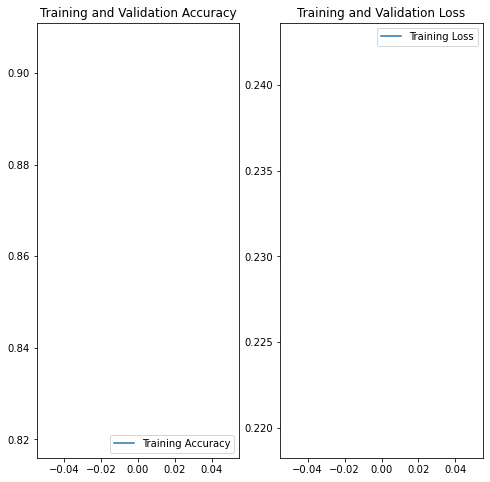

In [20]:
#history = model_history
accuracy = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
print(history.history['accuracy'])

[0.31258487701416016]


In [20]:
print(PATH)

data


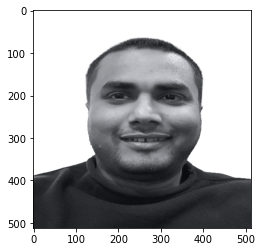

In [21]:
#img_path = f"{PATH}/test/IMG_1852.png"
#img_path = f"{PATH}/test/test1.png"
img_path = "test/Profile3.png"
#img_path = f"{PATH}/test/sahas-standing.png"
#img_path = f"{PATH}/test/sahas.png"

test_img = None
test_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(WIDTH, HEIGHT))
plt.imshow(test_img)

In [22]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


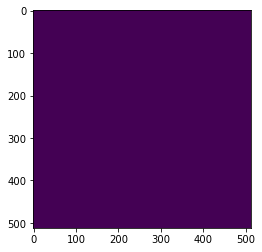

In [23]:
def display_mask(pred_mask):
    #preds=model.predict(image)  
    threshold = 0.000000001
    pred_mask[pred_mask > threshold] = 1.0
    pred_mask[pred_mask <= threshold] = 0.0 
    return pred_mask

def display_mask2(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

img_path = "test/Sahas.png"
pred_img = None
pred_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(WIDTH, HEIGHT))
plt.imshow(pred_img)

pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)

pred_img = tf.expand_dims(pred_img, 0)

pred_img = model.predict(pred_img)
output_mask = display_mask(pred_img)


output_mask = tf.squeeze(output_mask, axis=0)

mask_img2 = tf.keras.preprocessing.image.array_to_img(output_mask)

plt.imshow(mask_img2)


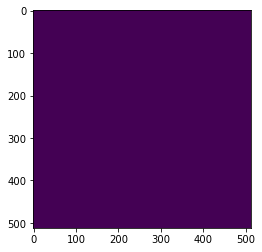

In [58]:
def display_mask3(pred_mask):
    #preds=model.predict(image)  
    threshold = 1.0
    val = pred_mask > threshold
    print(val)
    pred_mask[pred_mask > threshold] = 1.0
    pred_mask[pred_mask <= threshold] = 0.0 
    return pred_mask


img_path = "test/Profile3.png"
pred_img = None
pred_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(WIDTH, HEIGHT))
#plt.imshow(pred_img)

pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)

pred_img = tf.expand_dims(pred_img, 0)

pred_img = model.predict(pred_img)
output_mask = display_mask2(pred_img)


#output_mask = tf.squeeze(output_mask, axis=0)

mask_img3 = tf.keras.preprocessing.image.array_to_img(output_mask)

plt.imshow(mask_img3)